In [1]:
import pandas as pd
import numpy as np
import gc
import psutil
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score,  confusion_matrix, classification_report, precision_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import re
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from itertools import combinations

In [2]:
def memory():
    print(gc.collect())
    print(f"всего свободно памяти: {psutil.virtual_memory().available/1024**3: .2f}gb \nкод занимает: {psutil.Process().memory_info().rss/1024**3  : .2f}gb")

In [3]:
memory()

0
всего свободно памяти:  24.34gb 
код занимает:  0.23gb


In [4]:
df_genres = pd.read_json("goodreads_book_genres_initial.json", lines = True)
df_genres.head(10)

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}
5,287141,"{'history, historical fiction, biography': 9, ..."
6,378460,{'fiction': 2}
7,6066812,"{'fantasy, paranormal': 32, 'young-adult': 8, ..."
8,34883016,{'romance': 3}
9,287149,"{'non-fiction': 24, 'history, historical ficti..."


In [5]:
df_genres.isna().sum()

book_id    0
genres     0
dtype: int64

In [6]:
df_genres.shape

(2360655, 2)

In [7]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   book_id  int64 
 1   genres   object
dtypes: int64(1), object(1)
memory usage: 36.0+ MB


In [8]:
df_genres["book_id"].nunique()

2360655

In [9]:
df_genres["book_id"].duplicated().sum()

0

In [10]:
books2 = pd.read_csv("books.csv")
books2.head(10)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...


In [11]:
books2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [12]:
books2["book_id"].duplicated().sum()

0

In [13]:
df_genres.sort_values("book_id").head(10000)["book_id"]

861044         1
2083381        2
1584855        3
1211232        4
1028676        5
           ...  
245004     18986
245014     18988
245013     18989
130272     18990
805960     18991
Name: book_id, Length: 10000, dtype: int64

In [14]:
df_genres2 = df_genres[df_genres["book_id"].isin(books2["book_id"].tolist())]
df_genres2.shape

(5123, 2)

In [15]:
df_genres3 = df_genres[~df_genres["book_id"].isin(books2["book_id"].tolist())]
df_genres3.sort_values("book_id").head()

,book_id,genres
2108074,10002,{'fiction': 2}
2108075,10003,"{'fantasy, paranormal': 1}"
2108071,10004,"{'fiction': 70, 'fantasy, paranormal': 2, 'mys..."
2108072,10006,"{'fiction': 368, 'mystery, thriller, crime': 3..."
2108078,10008,{'fiction': 363}


In [16]:
df_genres2["book_id"].nunique(), df_genres["book_id"].nunique(), df_genres3["book_id"].nunique(),books2["book_id"].nunique()

(5123, 2360655, 2355532, 10000)

In [17]:
books = books2.merge(df_genres, on = "book_id", how = "inner")
books.shape

(5123, 24)

In [18]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url', 'genres'],
      dtype='object')

In [19]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5123 entries, 0 to 5122
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    5123 non-null   int64  
 1   goodreads_book_id          5123 non-null   int64  
 2   best_book_id               5123 non-null   int64  
 3   work_id                    5123 non-null   int64  
 4   books_count                5123 non-null   int64  
 5   isbn                       4769 non-null   object 
 6   isbn13                     4836 non-null   float64
 7   authors                    5123 non-null   object 
 8   original_publication_year  5113 non-null   float64
 9   original_title             4816 non-null   object 
 10  title                      5123 non-null   object 
 11  language_code              4556 non-null   object 
 12  average_rating             5123 non-null   float64
 13  ratings_count              5123 non-null   int64

In [20]:
books[books["original_title"].isna()]["original_title"]

57      NaN
127     NaN
203     NaN
290     NaN
328     NaN
       ... 
5096    NaN
5100    NaN
5101    NaN
5109    NaN
5110    NaN
Name: original_title, Length: 307, dtype: object

In [21]:
books.loc[books["original_title"].isna(),"original_title"] = books.loc[books["original_title"].isna(),"title"].str.split("(").str[0].str.strip()

In [22]:
books.iloc[[57,127,203,290],:]["original_title"]

57              Bridget Jones's Diary
127                  Ready Player One
203                    Goodnight Moon
290    Holy Bible: King James Version
Name: original_title, dtype: object

In [23]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5123 entries, 0 to 5122
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    5123 non-null   int64  
 1   goodreads_book_id          5123 non-null   int64  
 2   best_book_id               5123 non-null   int64  
 3   work_id                    5123 non-null   int64  
 4   books_count                5123 non-null   int64  
 5   isbn                       4769 non-null   object 
 6   isbn13                     4836 non-null   float64
 7   authors                    5123 non-null   object 
 8   original_publication_year  5113 non-null   float64
 9   original_title             5123 non-null   object 
 10  title                      5123 non-null   object 
 11  language_code              4556 non-null   object 
 12  average_rating             5123 non-null   float64
 13  ratings_count              5123 non-null   int64

In [24]:
books[books["title"]!=books["original_title"]][["title", "original_title"]]

,title,original_title
0,"The Hunger Games (The Hunger Games, #1)",The Hunger Games
1,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter and the Philosopher's Stone
2,"Twilight (Twilight, #1)",Twilight
6,The Hobbit,The Hobbit or There and Back Again
8,"Angels & Demons (Robert Langdon, #1)",Angels & Demons
...,...,...
5114,Gut: The Inside Story of Our Body’s Most Under...,Darm mit Charme
5115,"The King Beyond the Gate (The Drenai Saga, #2)",The King Beyond the Gate
5116,"Chasing The Night (Eve Duncan, #11; Catherine ...",Chasing The Night
5118,"Bayou Moon (The Edge, #2)",Bayou Moon


In [25]:
books[books["title"]==books["original_title"]][["title", "original_title"]]

,title,original_title
3,To Kill a Mockingbird,To Kill a Mockingbird
4,The Great Gatsby,The Great Gatsby
5,The Fault in Our Stars,The Fault in Our Stars
7,The Catcher in the Rye,The Catcher in the Rye
9,Pride and Prejudice,Pride and Prejudice
...,...,...
5112,The Comfort of Strangers,The Comfort of Strangers
5117,A Theory of Justice,A Theory of Justice
5120,The Mauritius Command,The Mauritius Command
5121,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...


In [26]:
iterations = 0
for i in books.index.tolist():
    if "(" in books.loc[i, "title"]:
        iterations +=1
        #print(books.loc[i, "title"])    
print(iterations)   

2316


In [27]:
a = books[books["original_title"] != books["title"]].index.tolist()
text = []
for i in a:
    b = books.loc[i,"original_title"]
    try:
        c = books.loc[i, "title"].replace(b, " ", 1)
        c = re.sub(r"[^a-zA-Z0-9]", " ", c)
        c1 = re.sub(r"[^0-9]", " ", c).strip()
        c2 = re.sub(r"[^a-zA-Z]", " ", c).strip()
        text.append([c1,c2])
    except:
        continue
print(len(text))   

2922


In [28]:
text[:10]

[['1', 'The Hunger Games'],
 ['1', 'Harry Potter and the Sorcerer s Stone  Harry Potter'],
 ['1', 'Twilight'],
 ['', 'The Hobbit'],
 ['1', 'Robert Langdon'],
 ['', 'The Kite Runner'],
 ['1', 'Divergent'],
 ['1984', ''],
 ['', 'Animal Farm'],
 ['', 'The Diary of a Young Girl']]

In [29]:

book_number,series_name = [],[]
for i in books.index.tolist():
    b = books.loc[i,"original_title"]
    try:
        c = books.loc[i, "title"].replace(b, " ", 1)
        if c !=books.loc[i, "title"]:
            c = re.sub(r"[^a-zA-Z0-9]", " ", c)
            c1 = re.sub(r"[^0-9]", " ", c).strip()
            if len(c1)>0:
                c1 = int(c1)
            else:
                c1 = 0    
            c2 = re.sub(r"[^a-zA-Z]", " ", c).strip()
            if len(c2)>0:
                series_name.append(c2)
            else:
                series_name.append("single")
            book_number.append(c1)
        else:
            book_number.append(0)
            series_name.append("single")
    except:
        book_number.append(0)
        series_name.append("single")
books["book_number"] = book_number
books["book_number"]=books["book_number"].astype(str)
books["series_name"] = series_name
print(len(book_number), len(series_name))   

5123 5123


In [30]:
a = books["series_name"].value_counts()
b = a[a==1].index.tolist()
books["series_name"]=books["series_name"].apply(lambda x: x.replace(x, "single") if x in b else x)

In [31]:
books["series_name"].value_counts()

series_name
single               4002
In Death               23
Stephanie Plum         14
Kay Scarpetta          13
Alex Cross             11
                     ... 
The Long Earth          2
The Darkest Minds       2
Pine Cove               2
Darkness Rising         2
Cherub                  2
Name: count, Length: 362, dtype: int64

In [32]:
books["book_id"].nunique()

5123

In [33]:
books.head(10)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,genres,book_number,series_name
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"{'fantasy, paranormal': 42143, 'young-adult': ...",1,The Hunger Games
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"{'fantasy, paranormal': 8249, 'children': 4168...",0,single
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"{'fantasy, paranormal': 54156, 'young-adult': ...",1,single
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,"{'fantasy, paranormal': 45018, 'young-adult': ...",0,single
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,"{'fiction': 12103, 'children': 8558, 'fantasy,...",0,single
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...,"{'fantasy, paranormal': 3630, 'children': 2050...",0,single
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...,"{'fantasy, paranormal': 295, 'fiction': 99, 'y...",0,single
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...,"{'fantasy, paranormal': 133, 'young-adult': 41...",0,single
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...,{},1,Robert Langdon
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...,"{'fantasy, paranormal': 295, 'fiction': 99, 'y...",0,single


In [34]:
a = books["book_number"].value_counts()[books["book_number"].value_counts()<10].index.tolist()
books[(books["book_number"].isin(a))&(books["series_name"]=="single")][["book_number","original_title","title", "series_name"]]

,book_number,original_title,title,series_name


In [35]:
books[books["series_name"]=="Hercule Poirot"][["title","series_name", "book_number"]]

,title,series_name,book_number
2860,"Five Little Pigs (Hercule Poirot, #24)",Hercule Poirot,24
2925,"Murder in Mesopotamia (Hercule Poirot, #14)",Hercule Poirot,14
3129,"Hercule Poirot's Christmas (Hercule Poirot, #20)",Hercule Poirot,20
3196,"The Big Four (Hercule Poirot, #5)",Hercule Poirot,5
3245,"The Murder on the Links (Hercule Poirot, #2)",Hercule Poirot,2
3460,"Death in the Clouds (Hercule Poirot, #12)",Hercule Poirot,12
3716,"Cat Among the Pigeons (Hercule Poirot, #32)",Hercule Poirot,32
3921,"Lord Edgware Dies (Hercule Poirot, #9)",Hercule Poirot,9
3956,"Elephants Can Remember (Hercule Poirot, #37)",Hercule Poirot,37


In [36]:
genres1 = []
for i in books.index.tolist():
    a = list(books["genres"][i].keys())
    genres1.extend(a)
genres = list(set(genres1))
print(genres)
print(f"всего жанров: {len(genres)}")

['comics, graphic', 'mystery, thriller, crime', 'children', 'poetry', 'fiction', 'young-adult', 'non-fiction', 'fantasy, paranormal', 'history, historical fiction, biography', 'romance']
всего жанров: 10


In [37]:
books3 = pd.json_normalize(books["genres"]).notna().astype("int8")
books3.columns = [f"book_{x}" for x in books3.columns]
books3

,"book_fantasy, paranormal",book_young-adult,book_fiction,book_children,"book_mystery, thriller, crime",book_romance,"book_history, historical fiction, biography",book_non-fiction,"book_comics, graphic",book_poetry
0,1,1,1,1,1,1,0,0,0,0
1,1,1,1,1,1,1,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0
3,1,1,1,1,1,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5118,1,0,1,0,0,0,0,0,0,0
5119,0,0,1,0,1,0,0,0,0,0
5120,1,0,1,0,1,0,0,0,0,0
5121,1,0,1,0,0,0,0,0,0,0


In [38]:
books = books.merge(books3, left_index = True, right_index = True, how = "inner")
books.shape

(5123, 36)

In [39]:
raitings = pd.read_csv("ratings.csv")
raitings.head(10)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5


In [40]:
raitings.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [41]:
raitings.shape

(5976479, 3)

In [42]:
raitings["book_id"].nunique()

10000

In [43]:
raitings["user_id"].nunique()

53424

In [44]:
raitings.duplicated().sum()

0

In [45]:
user_activity = raitings[["user_id", "book_id"]].groupby("user_id").agg(user_books_count = ("book_id", "count")).reset_index()
raitings = raitings.merge(user_activity, on = "user_id", how = "inner")

In [46]:
raitings.isnull().sum()

user_id             0
book_id             0
rating              0
user_books_count    0
dtype: int64

In [47]:
raitings2 = raitings[raitings["book_id"].isin(books["book_id"].tolist())]
raitings2.shape

(3330234, 4)

In [48]:
raitings2.head(10)

,user_id,book_id,rating,user_books_count
0,1,258,5,117
5,2,26,4,65
7,2,33,4,65
8,2,301,5,65
9,2,2686,5,65
10,2,3753,5,65
13,4,264,3,134
15,4,18,5,134
16,4,27,5,134
17,4,21,5,134


In [49]:
user_activity_in_it = raitings2.groupby("user_id").agg(user_books_count_in_it = ("book_id", "count")).reset_index()

In [50]:
user_activity_in_it

,user_id,user_books_count_in_it
0,1,66
1,2,36
2,3,53
3,4,87
4,5,49
...,...,...
53419,53420,68
53420,53421,71
53421,53422,77
53422,53423,47


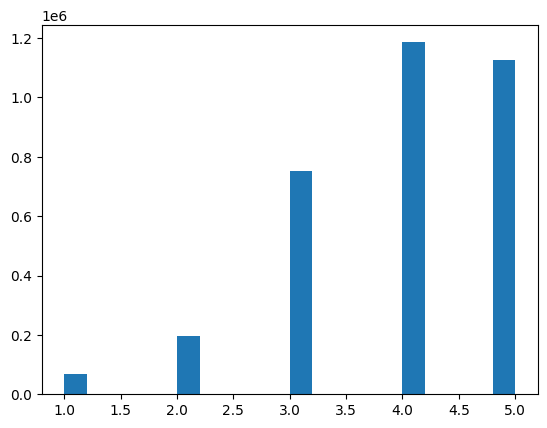

In [51]:
plt.hist(raitings2["rating"], bins = 20)
plt.show();

In [52]:
books.columns = [f"book_{x}" if "book" not in x else x for x in books.columns]
books

,book_id,goodreads_book_id,best_book_id,book_work_id,books_count,book_isbn,book_isbn13,book_authors,book_original_publication_year,book_original_title,...,"book_fantasy, paranormal",book_young-adult,book_fiction,book_children,"book_mystery, thriller, crime",book_romance,"book_history, historical fiction, biography",book_non-fiction,"book_comics, graphic",book_poetry
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,1,1,1,1,1,1,0,0,0,0
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,1,1,1,1,1,1,0,0,0,0
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,1,1,1,1,1,0,0,0,0,0
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,1,1,1,1,1,0,0,0,0,0
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5118,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,1,0,1,0,0,0,0,0,0,0
5119,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,0,0,1,0,1,0,0,0,0,0
5120,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,1,0,1,0,1,0,0,0,0,0
5121,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,1,0,1,0,0,0,0,0,0,0


In [53]:
books.columns.tolist()

['book_id',
 'goodreads_book_id',
 'best_book_id',
 'book_work_id',
 'books_count',
 'book_isbn',
 'book_isbn13',
 'book_authors',
 'book_original_publication_year',
 'book_original_title',
 'book_title',
 'book_language_code',
 'book_average_rating',
 'book_ratings_count',
 'book_work_ratings_count',
 'book_work_text_reviews_count',
 'book_ratings_1',
 'book_ratings_2',
 'book_ratings_3',
 'book_ratings_4',
 'book_ratings_5',
 'book_image_url',
 'book_small_image_url',
 'book_genres',
 'book_number',
 'book_series_name',
 'book_fantasy, paranormal',
 'book_young-adult',
 'book_fiction',
 'book_children',
 'book_mystery, thriller, crime',
 'book_romance',
 'book_history, historical fiction, biography',
 'book_non-fiction',
 'book_comics, graphic',
 'book_poetry']

In [54]:
books_list = ['book_id','books_count', 'book_authors', 'book_original_title', 'book_average_rating','book_ratings_count', 'book_work_text_reviews_count',  'book_number', 'book_series_name', 'book_fantasy, paranormal','book_young-adult',
              'book_fiction','book_children','book_mystery, thriller, crime','book_romance','book_history, historical fiction, biography','book_non-fiction', 'book_comics, graphic','book_poetry']

In [55]:
df_total = raitings.merge(books[books_list], on = "book_id", how = "inner").merge(user_activity_in_it, on = "user_id", how = "inner")
df_total.shape

(3330234, 23)

In [56]:
df_total["rating"].value_counts(normalize=True)

rating
4    0.355954
5    0.337861
3    0.225954
2    0.059324
1    0.020907
Name: proportion, dtype: float64

In [57]:
df_total.head(10)

,user_id,book_id,rating,user_books_count,books_count,book_authors,book_original_title,book_average_rating,book_ratings_count,book_work_text_reviews_count,...,book_young-adult,book_fiction,book_children,"book_mystery, thriller, crime",book_romance,"book_history, historical fiction, biography",book_non-fiction,"book_comics, graphic",book_poetry,user_books_count_in_it
0,1,258,5,117,279,"Carlos Ruiz Zafón, Lucia Graves",La sombra del viento,4.24,263685,24652,...,0,0,0,0,0,1,1,0,0,66
1,2,26,4,65,350,Dan Brown,The Da Vinci Code,3.79,1447148,41560,...,0,1,0,0,0,1,1,0,0,36
2,2,33,4,65,220,Arthur Golden,Memoirs of a Geisha,4.08,1300209,25605,...,1,1,0,0,0,0,0,0,0,36
3,2,301,5,65,1369,Joseph Conrad,Heart of Darkness,3.42,255576,9791,...,1,1,1,1,0,1,0,0,0,36
4,2,2686,5,65,60,"W. Chan Kim, Renée Mauborgne",Blue Ocean Strategy: How to Create Uncontested...,3.86,30665,679,...,0,1,0,0,1,1,0,0,0,36
5,2,3753,5,65,6,J.K. Rowling,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618,882,...,0,1,0,1,0,0,0,0,0,36
6,4,264,3,134,343,Ernest Hemingway,The Sun Also Rises,3.83,284988,9826,...,0,1,0,0,1,1,0,0,0,87
7,4,18,5,134,376,"J.K. Rowling, Mary GrandPré, Rufus Beck",Harry Potter and the Prisoner of Azkaban,4.53,1832823,36099,...,1,1,0,0,0,0,0,0,0,87
8,4,27,5,134,275,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince,4.54,1678823,27520,...,0,1,0,0,0,1,1,0,0,87
9,4,21,5,134,307,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix,4.46,1735368,28685,...,0,1,0,0,0,1,1,0,0,87


In [58]:
x_train, x_test, y_train, y_test = train_test_split(df_total.drop(columns = ["rating","book_average_rating"]), df_total[["rating", "book_average_rating"]], test_size=0.2, stratify=df_total["rating"], shuffle=True, random_state=42)

In [59]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [60]:
y_train["rating"].value_counts(normalize=True), y_test["rating"].value_counts(normalize=True)

(rating
 4    0.355954
 5    0.337861
 3    0.225954
 2    0.059324
 1    0.020907
 Name: proportion, dtype: float64,
 rating
 4    0.355954
 5    0.337861
 3    0.225954
 2    0.059325
 1    0.020907
 Name: proportion, dtype: float64)

In [61]:
x_train.shape, y_train.shape,  x_test.shape, y_test.shape

((2664187, 21), (2664187, 2), (666047, 21), (666047, 2))

In [62]:
x_train.isnull().sum(), x_test.isnull().sum()

(user_id                                        0
 book_id                                        0
 user_books_count                               0
 books_count                                    0
 book_authors                                   0
 book_original_title                            0
 book_ratings_count                             0
 book_work_text_reviews_count                   0
 book_number                                    0
 book_series_name                               0
 book_fantasy, paranormal                       0
 book_young-adult                               0
 book_fiction                                   0
 book_children                                  0
 book_mystery, thriller, crime                  0
 book_romance                                   0
 book_history, historical fiction, biography    0
 book_non-fiction                               0
 book_comics, graphic                           0
 book_poetry                                    0


In [63]:
x_train["user_id"].nunique(), x_test["user_id"].nunique()

(53424, 53410)

In [64]:
x_train["book_id"].nunique(),x_test["book_id"].nunique()

(5123, 5123)

In [65]:
memory()

0
всего свободно памяти:  21.51gb 
код занимает:  3.03gb


In [66]:
x_train

,user_id,book_id,user_books_count,books_count,book_authors,book_original_title,book_ratings_count,book_work_text_reviews_count,book_number,book_series_name,...,book_young-adult,book_fiction,book_children,"book_mystery, thriller, crime",book_romance,"book_history, historical fiction, biography",book_non-fiction,"book_comics, graphic",book_poetry,user_books_count_in_it
0,43557,29,155,1937,"William Shakespeare, Robert Jackson",An Excellent conceited Tragedie of Romeo and J...,1628519,14778,0,single,...,0,0,0,0,0,1,1,0,0,84
1,35532,5821,93,6,Kristen Proby,Rock With Me,28709,1475,0,single,...,0,1,0,1,0,0,0,0,0,46
2,26473,17,162,201,Suzanne Collins,Catching Fire,1831039,88538,2,The Hunger Games,...,0,1,0,0,0,0,0,0,0,93
3,9755,826,115,1150,"Kenneth Grahame, Gillian Avery",The Wind in the Willows,124612,4057,0,single,...,1,1,0,1,0,0,0,0,0,73
4,30728,213,103,1316,"Franz Kafka, Stanley Corngold",Die Verwandlung,364933,10252,0,single,...,0,1,0,1,0,1,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2664182,44637,458,161,63,Emily St. John Mandel,Station Eleven,160466,24215,0,single,...,0,1,0,1,0,0,0,0,0,85
2664183,11811,432,91,218,Isaac Asimov,"I, Robot",198368,4335,0,single,...,0,1,0,1,0,0,0,1,0,56
2664184,33379,478,114,558,"Daniel Defoe, Gerald McCann, Virginia Woolf",The Life and Strange Surprising Adventures of ...,178188,4603,0,single,...,0,0,0,0,0,1,1,0,0,66
2664185,20056,160,103,1725,Charles Dickens,Great Expectations,459247,12311,0,single,...,0,1,0,0,1,1,1,0,0,55


In [67]:
x_test

,user_id,book_id,user_books_count,books_count,book_authors,book_original_title,book_ratings_count,book_work_text_reviews_count,book_number,book_series_name,...,book_young-adult,book_fiction,book_children,"book_mystery, thriller, crime",book_romance,"book_history, historical fiction, biography",book_non-fiction,"book_comics, graphic",book_poetry,user_books_count_in_it
0,19996,155,100,453,J.R.R. Tolkien,The Two Towers,480446,6980,2,The Lord of the Rings,...,0,1,0,0,1,1,0,0,0,64
1,41759,282,100,153,Neil Gaiman,Coraline,316379,13905,0,single,...,0,1,0,0,0,1,0,0,0,61
2,36142,446,107,1106,Arthur Conan Doyle,A Study in Scarlet,201499,6954,0,single,...,0,1,0,0,1,0,0,0,0,55
3,53255,249,120,104,Jonathan Safran Foer,Extremely Loud and Incredibly Close,294726,21107,0,single,...,0,1,0,0,1,1,1,0,0,74
4,5505,2498,139,43,Mark Kurlansky,Salt: A World History,39402,2640,0,single,...,0,1,1,1,0,0,1,0,0,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666042,20263,5995,122,41,Harriet Lerner,The Dance of Anger: A Woman's Guide to Changin...,14640,481,0,single,...,0,0,0,0,0,0,0,0,1,75
666043,13658,451,140,122,"Jane Austen, Alfred MacAdam",Northanger Abbey,205167,8616,0,single,...,0,0,0,0,0,1,1,0,0,87
666044,5238,2015,130,146,Robert James Waller,The Bridges of Madison County,56428,3458,0,single,...,0,1,0,0,0,0,0,0,0,93
666045,31820,8,118,360,J.D. Salinger,The Catcher in the Rye,2044241,44920,0,single,...,1,1,1,1,0,0,0,0,0,61


In [68]:
genres = [f"book_{x}" for x in genres]
genres

['book_comics, graphic',
 'book_mystery, thriller, crime',
 'book_children',
 'book_poetry',
 'book_fiction',
 'book_young-adult',
 'book_non-fiction',
 'book_fantasy, paranormal',
 'book_history, historical fiction, biography',
 'book_romance']

In [69]:
user_prof_train = x_train.groupby("user_id")[genres].sum().reset_index()
user_prof_test = x_test.groupby("user_id")[genres].sum().reset_index()

In [70]:
user_prof_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53424 entries, 0 to 53423
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   user_id                                      53424 non-null  int64
 1   book_comics, graphic                         53424 non-null  int8 
 2   book_mystery, thriller, crime                53424 non-null  int8 
 3   book_children                                53424 non-null  int8 
 4   book_poetry                                  53424 non-null  int8 
 5   book_fiction                                 53424 non-null  int8 
 6   book_young-adult                             53424 non-null  int8 
 7   book_non-fiction                             53424 non-null  int8 
 8   book_fantasy, paranormal                     53424 non-null  int8 
 9   book_history, historical fiction, biography  53424 non-null  int8 
 10  book_romance          

In [71]:
user_prof_train.columns = [x.replace("book", "user") if "book" in x else x for x in user_prof_train.columns]
user_prof_test.columns = [x.replace("book", "user") if "book" in x else x for x in user_prof_test.columns]

In [72]:
user_prof_train

,user_id,"user_comics, graphic","user_mystery, thriller, crime",user_children,user_poetry,user_fiction,user_young-adult,user_non-fiction,"user_fantasy, paranormal","user_history, historical fiction, biography",user_romance
0,1,3,7,9,4,37,14,17,24,17,9
1,2,2,7,7,2,27,11,17,10,19,9
2,3,3,11,6,7,33,12,18,15,25,3
3,4,6,12,10,5,52,15,27,31,34,10
4,5,0,6,8,5,29,9,20,12,22,14
...,...,...,...,...,...,...,...,...,...,...,...
53419,53420,2,9,14,3,42,20,19,20,28,6
53420,53421,6,13,8,5,39,17,29,19,29,12
53421,53422,3,10,10,3,48,15,22,20,31,12
53422,53423,2,9,4,3,30,10,16,14,24,4


In [73]:
user_prof_test

,user_id,"user_comics, graphic","user_mystery, thriller, crime",user_children,user_poetry,user_fiction,user_young-adult,user_non-fiction,"user_fantasy, paranormal","user_history, historical fiction, biography",user_romance
0,1,0,2,0,0,12,3,5,7,6,3
1,2,2,0,1,0,4,0,2,2,2,0
2,3,3,0,0,1,6,0,7,1,5,2
3,4,0,4,4,1,15,9,7,6,7,3
4,5,0,1,0,3,7,0,4,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
53405,53420,4,3,1,1,10,4,7,7,8,2
53406,53421,1,1,2,4,12,4,2,8,5,3
53407,53422,1,5,3,0,13,4,6,8,11,4
53408,53423,2,2,2,1,7,2,6,3,5,2


In [74]:
stop_words = stopwords.words("english")
len(stop_words)

198

In [75]:
df_train = x_train.merge(user_prof_train, on = "user_id", how = "inner")
df_test = x_test.merge(user_prof_test, on = "user_id", how = "inner")
df_train.shape, df_test.shape

((2664187, 31), (666047, 31))

In [76]:
df_train

,user_id,book_id,user_books_count,books_count,book_authors,book_original_title,book_ratings_count,book_work_text_reviews_count,book_number,book_series_name,...,"user_comics, graphic","user_mystery, thriller, crime",user_children,user_poetry,user_fiction,user_young-adult,user_non-fiction,"user_fantasy, paranormal","user_history, historical fiction, biography",user_romance
0,43557,29,155,1937,"William Shakespeare, Robert Jackson",An Excellent conceited Tragedie of Romeo and J...,1628519,14778,0,single,...,4,13,11,7,59,20,25,24,37,15
1,35532,5821,93,6,Kristen Proby,Rock With Me,28709,1475,0,single,...,3,7,7,4,28,9,17,9,23,5
2,26473,17,162,201,Suzanne Collins,Catching Fire,1831039,88538,2,The Hunger Games,...,7,16,4,7,56,10,32,15,47,12
3,9755,826,115,1150,"Kenneth Grahame, Gillian Avery",The Wind in the Willows,124612,4057,0,single,...,4,14,11,6,38,12,31,21,30,8
4,30728,213,103,1316,"Franz Kafka, Stanley Corngold",Die Verwandlung,364933,10252,0,single,...,5,4,3,3,31,8,28,9,31,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2664182,44637,458,161,63,Emily St. John Mandel,Station Eleven,160466,24215,0,single,...,7,12,9,2,53,19,28,29,39,12
2664183,11811,432,91,218,Isaac Asimov,"I, Robot",198368,4335,0,single,...,6,12,7,5,33,11,17,18,27,10
2664184,33379,478,114,558,"Daniel Defoe, Gerald McCann, Virginia Woolf",The Life and Strange Surprising Adventures of ...,178188,4603,0,single,...,1,15,16,5,46,27,18,27,27,11
2664185,20056,160,103,1725,Charles Dickens,Great Expectations,459247,12311,0,single,...,2,6,4,4,31,5,28,11,21,7


In [77]:
df_train.columns

Index(['user_id', 'book_id', 'user_books_count', 'books_count', 'book_authors',
       'book_original_title', 'book_ratings_count',
       'book_work_text_reviews_count', 'book_number', 'book_series_name',
       'book_fantasy, paranormal', 'book_young-adult', 'book_fiction',
       'book_children', 'book_mystery, thriller, crime', 'book_romance',
       'book_history, historical fiction, biography', 'book_non-fiction',
       'book_comics, graphic', 'book_poetry', 'user_books_count_in_it',
       'user_comics, graphic', 'user_mystery, thriller, crime',
       'user_children', 'user_poetry', 'user_fiction', 'user_young-adult',
       'user_non-fiction', 'user_fantasy, paranormal',
       'user_history, historical fiction, biography', 'user_romance'],
      dtype='object')

In [78]:
cols_dict = {}
for column in df_train.columns.tolist():
    if "," in column or "-" in column:
        new_column = column.replace(",", "_").replace("-", "_").replace(" ", "_").replace("__", "_")
        cols_dict[column]=new_column
        print(new_column)
df_train = df_train.rename(columns = cols_dict)

book_fantasy_paranormal
book_young_adult
book_mystery_thriller_crime
book_history_historical_fiction_biography
book_non_fiction
book_comics_graphic
user_comics_graphic
user_mystery_thriller_crime
user_young_adult
user_non_fiction
user_fantasy_paranormal
user_history_historical_fiction_biography


In [79]:
cols_dict = {}
for column in df_test.columns.tolist():
    if "," in column or "-" in column:
        new_column = column.replace(",", "_").replace("-", "_").replace(" ", "_").replace("__", "_")
        cols_dict[column]=new_column
        print(new_column)
df_test = df_test.rename(columns = cols_dict)

book_fantasy_paranormal
book_young_adult
book_mystery_thriller_crime
book_history_historical_fiction_biography
book_non_fiction
book_comics_graphic
user_comics_graphic
user_mystery_thriller_crime
user_young_adult
user_non_fiction
user_fantasy_paranormal
user_history_historical_fiction_biography


In [80]:
df_train.select_dtypes(include="number").columns

Index(['user_id', 'book_id', 'user_books_count', 'books_count',
       'book_ratings_count', 'book_work_text_reviews_count',
       'book_fantasy_paranormal', 'book_young_adult', 'book_fiction',
       'book_children', 'book_mystery_thriller_crime', 'book_romance',
       'book_history_historical_fiction_biography', 'book_non_fiction',
       'book_comics_graphic', 'book_poetry', 'user_books_count_in_it',
       'user_comics_graphic', 'user_mystery_thriller_crime', 'user_children',
       'user_poetry', 'user_fiction', 'user_young_adult', 'user_non_fiction',
       'user_fantasy_paranormal', 'user_history_historical_fiction_biography',
       'user_romance'],
      dtype='object')

In [81]:
df_train.select_dtypes(include="object").columns

Index(['book_authors', 'book_original_title', 'book_number',
       'book_series_name'],
      dtype='object')

In [82]:
df_train["book_authors"].nunique()

2908

In [83]:
re.sub(r"\s+", " ", df_train["book_authors"][0])

'William Shakespeare, Robert Jackson'

In [84]:
df_train["book_authors"][0].split()

['William', 'Shakespeare,', 'Robert', 'Jackson']

In [85]:
df_train["book_series_name"].nunique(), df_test["book_series_name"].nunique()

(362, 362)

In [86]:
train, test = [],[]
for i, j in zip(df_train["book_series_name"].index.tolist(),df_test["book_series_name"].index.tolist()):
    a = [x for x in df_train["book_series_name"][i].split()]
    b = [x for x in df_test["book_series_name"][j].split()]
    train.extend(a)
    test.extend(b)
len(Counter(train)), len(Counter(test))    

(590, 590)

In [87]:
books["book_series_rename"]=books["book_series_name"].str.lower().str.strip().str.replace(r"[^a-zA-Z0-9]+", "_", regex = True)

In [88]:
books["book_series_rename"]=books["book_series_name"].str.lower().str.strip().str.replace(r"[^a-zA-Z0-9]+", "_", regex = True)
books["book_authors_rename"] = books["book_authors"].str.lower().str.strip().str.replace(r"[^a-zA-Z0-9]+", "_", regex = True)
books["book_original_title_rename"] = books["book_original_title"].str.lower().str.strip().str.replace(r"[^a-zA-Z0-9]+", "_", regex = True)
books["book_series_rename"].nunique(),books["book_series_name"].nunique(), books["book_authors_rename"].nunique(),books["book_authors"].nunique(),books["book_original_title_rename"].nunique(), books["book_original_title"].nunique()


(362, 362, 2887, 2908, 4975, 5075)

In [89]:
a = books[books["book_authors_rename"].str.len()<3][["book_authors_rename", "book_series_name"]].index.tolist()

In [90]:
books.loc[a,["book_authors_rename", "book_authors", "book_original_title"]]

,book_authors_rename,book_authors,book_original_title
695,_,أحمد مراد,الفيل الأزرق
1318,_,أحمد خالد توفيق,يوتوبيا
1625,_,خولة حمدي,في قلبي أنثى عبرية
1702,_,أثير عبدالله النشمي,فلتغفرى
1760,_,أحمد مراد,ڤيرتيجو
2124,_,أحمد مراد,1919
2299,_,منى المرشود,أنت لي
2500,_,أحمد حلمي,28 حرف
2545,_,أثير عبدالله النشمي,في ديسمبر تنتهي كل الأحلام
2778,_,ياسر حارب,بيكاسو وستاربكس


In [91]:
books[books["book_authors_rename"].str.len()<3][["book_authors_rename", "book_series_name"]]

,book_authors_rename,book_series_name
695,_,single
1318,_,single
1625,_,single
1702,_,single
1760,_,single
2124,_,single
2299,_,single
2500,_,single
2545,_,single
2778,_,single


In [92]:
books[books["book_original_title_rename"].str.len()<3][["book_authors_rename", "book_series_name", "book_original_title_rename", "book_original_title"]]

,book_authors_rename,book_series_name,book_original_title_rename,book_original_title
61,homer_robert_fagles_e_v_rieu_fr_d_ric_mugler_b...,single,_,Ὀδύσσεια
204,homer_robert_fagles_fr_d_ric_mugler_bernard_knox,single,_,Ἰλιάς
431,sophocles_j_e_thomas,single,_,Οἰδίπους Τύραννος
469,hiromu_arakawa_akira_watanabe,single,_1,鋼の錬金術師 1
546,fyodor_dostoyevsky_constance_garnett_alan_myer...,single,_,Идиот
...,...,...,...,...
4978,bisco_hatori,single,_1,"千年の雪, 1"
5075,bisco_hatori,single,_4,桜蘭高校ホスト部 4
5093,_,single,_,زغازيغ
5102,matsuri_hino_tomo_kimura,single,_2,ヴァンパイア騎士 2


In [93]:
books.head(10)

,book_id,goodreads_book_id,best_book_id,book_work_id,books_count,book_isbn,book_isbn13,book_authors,book_original_publication_year,book_original_title,...,book_children,"book_mystery, thriller, crime",book_romance,"book_history, historical fiction, biography",book_non-fiction,"book_comics, graphic",book_poetry,book_series_rename,book_authors_rename,book_original_title_rename
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,1,1,1,0,0,0,0,the_hunger_games,suzanne_collins,the_hunger_games
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,1,1,1,0,0,0,0,single,j_k_rowling_mary_grandpr_,harry_potter_and_the_philosopher_s_stone
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,1,1,0,0,0,0,0,single,stephenie_meyer,twilight
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,1,1,0,0,0,0,0,single,harper_lee,to_kill_a_mockingbird
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,1,1,0,0,0,0,0,single,f_scott_fitzgerald,the_great_gatsby
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,1,0,1,0,0,0,0,single,john_green,the_fault_in_our_stars
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,1,1,0,0,0,0,0,single,j_r_r_tolkien,the_hobbit_or_there_and_back_again
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,1,1,0,0,0,0,0,single,j_d_salinger,the_catcher_in_the_rye
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,0,0,0,0,0,0,0,robert_langdon,dan_brown,angels_demons
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,1,1,0,0,0,0,0,single,jane_austen,pride_and_prejudice


In [154]:
title_vectorizer = CountVectorizer(stop_words=None, max_features=100, dtype = np.int8)
title_vec = title_vectorizer.fit_transform(books["book_original_title_rename"])
series_vectorizer = CountVectorizer(stop_words=None, max_features=100, dtype=np.int8)
series_vec = series_vectorizer.fit_transform(books["book_series_rename"])
authors_vectorizer = CountVectorizer(stop_words=None, max_features=100, dtype=np.int8)
authors_vec = authors_vectorizer.fit_transform(books["book_authors_rename"])

In [161]:
vectorizers = {"title": title_vec, "authors":authors_vec, "series": series_vec}
for k,v in vectorizers.items():
    if not os.path.isdir("vectors_module8"):
        os.makedirs("vectors_module8")
    v = v.toarray()    
    np.save(f"vectors_module8/{k}.npy", v)

In [162]:
books.shape, title_vec.shape

((5123, 39), (5123, 100))

In [163]:
df_vectors = books["book_id"]
df_title = pd.DataFrame(title_vec.toarray(), columns = [f"title_{i}" for i in title_vectorizer.get_feature_names_out().tolist()], index = df_vectors.index.tolist())
df_authors = pd.DataFrame(authors_vec.toarray(), columns = [f"author_{i}" for i in authors_vectorizer.get_feature_names_out().tolist()], index = df_vectors.index.tolist())
df_series = pd.DataFrame(series_vec.toarray(), columns = [f"serie_{i}" for i in series_vectorizer.get_feature_names_out().tolist()], index = df_vectors.index.tolist())
df_vectors = pd.concat([books["book_id"], df_authors, df_title, df_series], axis = 1)

In [164]:
df_vectors.shape

(5123, 301)

In [165]:
df_vectors.filter(like="title").columns

Index(['title__1', 'title__2', 'title__4', 'title_a_clash_of_kings',
       'title_a_grief_observed', 'title_a_song_of_ice_and_fire',
       'title_beautiful_redemption', 'title_between_the_lines',
       'title_blackout', 'title_breathe', 'title_cold_fire', 'title_crush',
       'title_dark_reunion', 'title_dawn', 'title_defiance', 'title_eve',
       'title_faking_it', 'title_fallen', 'title_feed', 'title_gone',
       'title_heat', 'title_legend', 'title_lucky', 'title_midnight',
       'title_more_than_this', 'title_naked', 'title_nemesis',
       'title_nevermore', 'title_perfect', 'title_persepolis', 'title_private',
       'title_reunion', 'title_selected_poems', 'title_shock_wave',
       'title_snuff', 'title_stone_soup', 'title_the_awakening',
       'title_the_bar_code_tattoo_point_thriller_',
       'title_the_barefoot_contessa_cookbook',
       'title_the_battle_for_skandia_ranger_s_apprentice_4_',
       'title_the_battle_of_the_labyrinth', 'title_the_beatles_anthology',


In [166]:
df_vectors.to_parquet("vectors_module8/book_vectors.parquet", engine = "fastparquet", index = False)

In [167]:
memory()

6749
всего свободно памяти:  17.92gb 
код занимает:  3.70gb


In [168]:
df_train.columns

Index(['user_id', 'book_id', 'user_books_count', 'books_count', 'book_authors',
       'book_original_title', 'book_ratings_count',
       'book_work_text_reviews_count', 'book_number', 'book_series_name',
       'book_fantasy_paranormal', 'book_young_adult', 'book_fiction',
       'book_children', 'book_mystery_thriller_crime', 'book_romance',
       'book_history_historical_fiction_biography', 'book_non_fiction',
       'book_comics_graphic', 'book_poetry', 'user_books_count_in_it',
       'user_young_adult', 'user_fantasy_paranormal', 'user_children',
       'user_history_historical_fiction_biography', 'user_non_fiction',
       'user_comics_graphic', 'user_mystery_thriller_crime', 'user_fiction',
       'user_romance', 'user_poetry'],
      dtype='object')

In [169]:
features = ['book_id', 'user_books_count', 'books_count',
       'book_ratings_count', 'book_work_text_reviews_count',
       'book_number', 'book_non_fiction',
       'book_history_historical_fiction_biography', 'book_fiction',
       'book_mystery_thriller_crime', 'book_fantasy_paranormal',
       'book_young_adult', 'book_children', 'book_poetry',
       'book_comics_graphic', 'book_romance', 'user_fiction',
       'user_fantasy_paranormal', 'user_children', 'user_non_fiction',
       'user_mystery_thriller_crime', 'user_comics_graphic', 'user_romance',
       'user_young_adult', 'user_history_historical_fiction_biography',
       'user_poetry', 'user_books_count_in_it']

In [170]:
df_train= df_train[features]
df_test = df_test[features]

In [171]:
df_train_total = df_train.merge(df_vectors, on = "book_id", how = "inner")
df_test_total = df_test.merge(df_vectors, on = "book_id", how = "inner")

In [172]:
df_train_total.shape,df_test_total.shape

((2664187, 327), (666047, 327))

In [173]:
memory()

0
всего свободно памяти:  16.84gb 
код занимает:  4.77gb


In [174]:
df_train_total.to_parquet("vectors_module8/df_train_module8.parquet", engine="fastparquet", index=False)
df_test_total.to_parquet("vectors_module8/df_test_module8.parquet", engine="fastparquet", index=False)
y_train.to_parquet("vectors_module8/y_train_module8.parquet", engine = "fastparquet",index=False)
y_test.to_parquet("vectors_module8/y_test_module8.parquet",engine = "fastparquet",index=False)

In [4]:
df_train = pd.read_parquet("vectors_module8/df_train_module8.parquet", engine="fastparquet")
df_test = pd.read_parquet("vectors_module8/df_test_module8.parquet", engine="fastparquet")
y_train=pd.read_parquet("vectors_module8/y_train_module8.parquet", engine = "fastparquet")
y_test=pd.read_parquet("vectors_module8/y_test_module8.parquet",engine = "fastparquet")
df_train= df_train.drop(columns = ['book_id'])
df_test= df_test.drop(columns = ['book_id'])
df_train.shape, y_train.shape, df_test.shape,y_test.shape

((2664187, 326), (2664187, 2), (666047, 326), (666047, 2))

In [5]:
df_train.select_dtypes(include="number").columns.tolist()[:30], df_train.select_dtypes(include="object").columns.tolist()

(['user_books_count',
  'books_count',
  'book_ratings_count',
  'book_work_text_reviews_count',
  'book_non_fiction',
  'book_history_historical_fiction_biography',
  'book_fiction',
  'book_mystery_thriller_crime',
  'book_fantasy_paranormal',
  'book_young_adult',
  'book_children',
  'book_poetry',
  'book_comics_graphic',
  'book_romance',
  'user_fiction',
  'user_fantasy_paranormal',
  'user_children',
  'user_non_fiction',
  'user_mystery_thriller_crime',
  'user_comics_graphic',
  'user_romance',
  'user_young_adult',
  'user_history_historical_fiction_biography',
  'user_poetry',
  'user_books_count_in_it',
  'author_abbi_glines',
  'author_agatha_christie',
  'author_ally_carter',
  'author_anita_shreve',
  'author_anne_mccaffrey'],
 ['book_number'])

In [28]:
num_features = ['user_books_count','books_count','book_ratings_count','book_work_text_reviews_count','user_books_count_in_it']
cat_features = ['book_number']

In [20]:
memory()

692
всего свободно памяти:  19.84gb 
код занимает:  1.67gb


In [21]:
titles = df_train.filter(like="title").columns.tolist()
authors = df_train.filter(like="author").columns.tolist()
series = df_train.filter(like = "serie_").columns.tolist()

In [22]:
len(titles), len(authors), len(series)

(100, 100, 101)

In [23]:
authors[78]

'author_rachel_caine'

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ("scaller", StandardScaler(), num_features),
    ("ohe", OneHotEncoder(handle_unknown="ignore", dtype="int8"), cat_features)],
                                remainder="passthrough")


In [25]:
pipeline_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMRegressor(objective="regression", verbose = -1))])
pipeline_class = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(objective="multiclass", verbose = -1, class_weight="balanced"))])

In [26]:
features_drop = [[], titles, authors, series, titles+authors, titles+series,series+authors,titles+authors+series]
for i in features_drop:
    df_train1 = df_train.copy()
    df_test1 = df_test.copy()
    df_train1 = df_train1.drop(columns = i)
    df_test1 = df_test1.drop(columns = i)
    pipeline_reg.fit(df_train1, y_train["rating"])
    pred_reg= pipeline_reg.predict(df_test1)
    rmse = np.sqrt(mean_squared_error(y_test["rating"], pred_reg))
    print(rmse)

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9700712458334032


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9695756057189484


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9731353941808506


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9731574562443175


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9786033452116442


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9717377512604901


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.977339417258022


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9720155375614076


In [27]:
features_drop = [[], titles, authors, series, titles+authors, titles+series,series+authors,titles+authors+series]
for i in features_drop:
    df_train1 = df_train.copy()
    df_test1 = df_test.copy()
    df_train1 = df_train1.drop(columns = i)
    df_test1 = df_test1.drop(columns = i)
    pipeline_class.fit(df_train1, y_train["rating"])
    pred_class = pipeline_class.predict(df_test1)
    print(precision_score(y_test["rating"], pred_class, average="micro"))
    print(classification_report(y_test["rating"], pred_class))

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.17898887015480888
              precision    recall  f1-score   support

           1       0.04      0.34      0.07     13925
           2       0.07      0.51      0.12     39513
           3       0.26      0.13      0.17    150496
           4       0.40      0.03      0.05    237082
           5       0.46      0.30      0.37    225031

    accuracy                           0.18    666047
   macro avg       0.24      0.26      0.16    666047
weighted avg       0.36      0.18      0.19    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.18769846572389035
              precision    recall  f1-score   support

           1       0.03      0.61      0.06     13925
           2       0.07      0.12      0.09     39513
           3       0.26      0.25      0.25    150496
           4       0.39      0.09      0.15    237082
           5       0.49      0.23      0.31    225031

    accuracy                           0.19    666047
   macro avg       0.25      0.26      0.17    666047
weighted avg       0.37      0.19      0.22    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.2443010778518633
              precision    recall  f1-score   support

           1       0.04      0.37      0.07     13925
           2       0.07      0.21      0.11     39513
           3       0.26      0.33      0.29    150496
           4       0.39      0.07      0.12    237082
           5       0.44      0.37      0.40    225031

    accuracy                           0.24    666047
   macro avg       0.24      0.27      0.20    666047
weighted avg       0.35      0.24      0.25    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.17396069646736642
              precision    recall  f1-score   support

           1       0.03      0.54      0.06     13925
           2       0.07      0.33      0.11     39513
           3       0.27      0.09      0.13    150496
           4       0.40      0.06      0.10    237082
           5       0.47      0.30      0.37    225031

    accuracy                           0.17    666047
   macro avg       0.25      0.27      0.15    666047
weighted avg       0.37      0.17      0.20    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.2293892172774594
              precision    recall  f1-score   support

           1       0.04      0.39      0.07     13925
           2       0.07      0.25      0.11     39513
           3       0.26      0.28      0.27    150496
           4       0.39      0.08      0.13    237082
           5       0.44      0.34      0.38    225031

    accuracy                           0.23    666047
   macro avg       0.24      0.27      0.19    666047
weighted avg       0.35      0.23      0.25    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.15858790745998405
              precision    recall  f1-score   support

           1       0.03      0.42      0.06     13925
           2       0.06      0.46      0.11     39513
           3       0.26      0.15      0.19    150496
           4       0.40      0.03      0.05    237082
           5       0.49      0.24      0.32    225031

    accuracy                           0.16    666047
   macro avg       0.25      0.26      0.15    666047
weighted avg       0.37      0.16      0.18    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.21143402792895996
              precision    recall  f1-score   support

           1       0.03      0.42      0.06     13925
           2       0.07      0.21      0.10     39513
           3       0.25      0.33      0.29    150496
           4       0.38      0.10      0.15    237082
           5       0.48      0.24      0.32    225031

    accuracy                           0.21    666047
   macro avg       0.24      0.26      0.18    666047
weighted avg       0.36      0.21      0.24    666047



C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.198693185315751
              precision    recall  f1-score   support

           1       0.05      0.25      0.08     13925
           2       0.07      0.53      0.12     39513
           3       0.25      0.14      0.18    150496
           4       0.39      0.02      0.04    237082
           5       0.45      0.36      0.40    225031

    accuracy                           0.20    666047
   macro avg       0.24      0.26      0.16    666047
weighted avg       0.35      0.20      0.20    666047



In [29]:
pipeline_class1 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(objective="multiclass", verbose = -1))])
pipeline_class1.fit(df_train, y_train["rating"])
pred_class1 = pipeline_class1.predict(df_test)
print(precision_score(y_test["rating"], pred_class1, average="micro"))
print(classification_report(y_test["rating"], pred_class1))

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.38036504931333676
              precision    recall  f1-score   support

           1       0.08      0.02      0.03     13925
           2       0.30      0.00      0.00     39513
           3       0.32      0.02      0.04    150496
           4       0.37      0.64      0.47    237082
           5       0.41      0.44      0.42    225031

    accuracy                           0.38    666047
   macro avg       0.29      0.22      0.19    666047
weighted avg       0.36      0.38      0.32    666047



In [4]:
from sentence_transformers import SentenceTransformer

In [21]:
df_train = pd.read_parquet("vectors_module8/df_train_module8.parquet", engine="fastparquet")
df_test = pd.read_parquet("vectors_module8/df_test_module8.parquet", engine="fastparquet")
y_train=pd.read_parquet("vectors_module8/y_train_module8.parquet", engine = "fastparquet")
y_test=pd.read_parquet("vectors_module8/y_test_module8.parquet",engine = "fastparquet")
df_train.shape, y_train.shape, df_test.shape,y_test.shape

((2664187, 327), (2664187, 2), (666047, 327), (666047, 2))

In [22]:
memory()

249
всего свободно памяти:  21.38gb 
код занимает:  2.95gb


In [6]:
books_descr = pd.read_csv("book_descr.csv")
books_descr.head()

,book_id,descr,descr_vecs
0,1,"In a future North America, where the rulers of...",[ 0.11025178 -0.21036306 -0.02822943 0.266000...
1,2,NaN,[-2.0151265 -0.5475724 -0.34907195 0.067971...
2,3,NaN,[-2.0151265 -0.5475724 -0.34907195 0.067971...
3,4,Harper Lee's Pulitzer Prize-winning masterwork...,[ 2.73116946e-01 -1.85827732e-01 -1.73755307e-...
4,5,A young man newly rich tries to recapture the ...,[ 0.07466012 -0.37611896 -0.02056331 0.190791...


In [7]:
books_descr["book_id"].nunique()

10000

In [8]:
books_descr.duplicated().sum()

0

In [9]:
books_descr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   book_id     10000 non-null  int64 
 1   descr       4893 non-null   object
 2   descr_vecs  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [11]:
books_descr1 = books_descr[books_descr["descr"].notna()][["book_id", "descr"]].reset_index(drop = True)
books_descr1

,book_id,descr
0,1,"In a future North America, where the rulers of..."
1,4,Harper Lee's Pulitzer Prize-winning masterwork...
2,5,A young man newly rich tries to recapture the ...
3,6,Now a Major Motion Picture TODAY Book Club pic...
4,7,"Bilbo Baggins, a respectable, well-to-do hobbi..."
...,...,...
4888,9991,BOOKER PRIZE WINNER • A modern classic that re...
4889,9992,This is a world dominated by the wild. Man liv...
4890,9993,This radical new approach turns our entire und...
4891,9994,Discusses the possible connections between the...


In [10]:
books_descr["descr"]=books_descr["descr"].fillna("empty")

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [12]:
vectors= model.encode(books_descr["descr"])

In [13]:
vectors1= model.encode(books_descr1["descr"])

In [13]:
vectors.shape

(10000, 384)

In [14]:
vectors1.shape

(4893, 384)

In [15]:
df_svec1 = pd.DataFrame(vectors1, columns = [f'col_{i}' for i in range(vectors1.shape[1])], index = books_descr1.index.tolist())
books_descr1 = books_descr1.merge(df_svec1, left_index = True, right_index = True, how = "inner")
books_descr1

,book_id,descr,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_374,col_375,col_376,col_377,col_378,col_379,col_380,col_381,col_382,col_383
0,1,"In a future North America, where the rulers of...",0.067644,0.085992,0.002493,-0.092401,-0.015397,0.076885,-0.008558,-0.043703,...,0.065679,-0.035920,0.044733,0.012599,-0.061958,0.045766,0.044409,-0.009835,-0.031044,0.029449
1,4,Harper Lee's Pulitzer Prize-winning masterwork...,0.018452,0.023446,-0.033819,-0.023287,-0.016800,0.100580,0.058062,-0.033420,...,0.012523,0.000198,0.003757,0.048219,-0.064856,0.010355,0.114138,-0.019254,0.005101,-0.031777
2,5,A young man newly rich tries to recapture the ...,-0.056265,-0.017900,0.055242,0.011415,0.003212,0.005103,0.030360,-0.070748,...,0.004942,-0.032639,0.015280,0.111522,-0.020044,0.005535,0.068233,-0.021184,0.037798,0.046354
3,6,Now a Major Motion Picture TODAY Book Club pic...,-0.035928,-0.054201,0.107164,0.012798,0.010087,0.077838,0.020408,0.038408,...,-0.040473,-0.037004,-0.010399,0.113337,-0.047627,-0.075053,0.069408,-0.091132,0.041140,0.010966
4,7,"Bilbo Baggins, a respectable, well-to-do hobbi...",0.050618,0.017817,-0.041549,0.014398,-0.038780,-0.046365,0.127346,-0.018732,...,0.036781,0.039637,0.036924,0.006774,-0.022482,0.003633,-0.011850,0.016483,-0.018903,-0.029186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4888,9991,BOOKER PRIZE WINNER • A modern classic that re...,0.018088,0.055292,-0.062575,0.033879,0.004614,0.026711,0.075372,0.029159,...,0.076028,-0.041171,-0.000840,-0.040481,-0.049065,0.077354,0.082738,-0.076048,-0.084973,-0.052853
4889,9992,This is a world dominated by the wild. Man liv...,0.125046,0.085065,0.017662,0.089975,0.036964,-0.003278,0.019608,-0.134085,...,0.046170,-0.073271,0.057112,0.070447,0.016600,-0.036557,0.025652,-0.069949,-0.014235,0.038507
4890,9993,This radical new approach turns our entire und...,-0.077059,0.048297,0.018263,0.025546,0.034500,0.038439,-0.134013,-0.048278,...,0.065492,0.026147,0.003530,0.094638,-0.082130,0.030450,0.111571,-0.029121,-0.019864,0.033154
4891,9994,Discusses the possible connections between the...,-0.038995,0.038342,-0.028095,0.059567,0.031005,-0.036725,0.052378,-0.063068,...,0.045567,-0.043279,-0.010558,0.052392,-0.012665,0.008109,0.079320,-0.031809,-0.000258,0.039535


In [17]:
df_svec = pd.DataFrame(vectors, columns = [f'col_{i}' for i in range(vectors.shape[1])], index = books_descr.index.tolist())
books_descr = books_descr.merge(df_svec, left_index = True, right_index = True, how = "inner")
books_descr.head(10)

,book_id,descr,descr_vecs,col_0,col_1,col_2,col_3,col_4,col_5,col_6,...,col_374,col_375,col_376,col_377,col_378,col_379,col_380,col_381,col_382,col_383
0,1,"In a future North America, where the rulers of...",[ 0.11025178 -0.21036306 -0.02822943 0.266000...,0.067644,0.085992,0.002493,-0.092401,-0.015397,0.076885,-0.008558,...,0.065679,-0.035920,0.044733,0.012599,-0.061958,0.045766,0.044409,-0.009835,-0.031044,0.029449
1,2,empty,[-2.0151265 -0.5475724 -0.34907195 0.067971...,0.070799,0.035285,-0.056988,0.100980,-0.015825,0.013477,0.091979,...,0.023554,-0.022466,0.080156,0.094672,-0.048027,0.014772,0.098558,-0.014397,-0.007345,-0.073503
2,3,empty,[-2.0151265 -0.5475724 -0.34907195 0.067971...,0.070799,0.035285,-0.056988,0.100980,-0.015825,0.013477,0.091979,...,0.023554,-0.022466,0.080156,0.094672,-0.048027,0.014772,0.098558,-0.014397,-0.007345,-0.073503
3,4,Harper Lee's Pulitzer Prize-winning masterwork...,[ 2.73116946e-01 -1.85827732e-01 -1.73755307e-...,0.018452,0.023446,-0.033819,-0.023287,-0.016800,0.100580,0.058062,...,0.012523,0.000198,0.003757,0.048219,-0.064856,0.010355,0.114138,-0.019254,0.005101,-0.031777
4,5,A young man newly rich tries to recapture the ...,[ 0.07466012 -0.37611896 -0.02056331 0.190791...,-0.056265,-0.017900,0.055242,0.011415,0.003212,0.005103,0.030360,...,0.004942,-0.032639,0.015280,0.111522,-0.020044,0.005535,0.068233,-0.021184,0.037798,0.046354
5,6,Now a Major Motion Picture TODAY Book Club pic...,[ 0.03563817 -0.24943407 -0.10899159 0.158770...,-0.035928,-0.054201,0.107164,0.012798,0.010087,0.077838,0.020408,...,-0.040473,-0.037004,-0.010399,0.113337,-0.047627,-0.075053,0.069408,-0.091132,0.041140,0.010966
6,7,"Bilbo Baggins, a respectable, well-to-do hobbi...",[-5.63431680e-02 -3.11299950e-01 1.86543912e-...,0.050618,0.017817,-0.041549,0.014398,-0.038780,-0.046365,0.127346,...,0.036781,0.039637,0.036924,0.006774,-0.022482,0.003633,-0.011850,0.016483,-0.018903,-0.029186
7,8,J.D. Salinger's classic of adolescent angst is...,[ 0.12205419 -0.27570552 0.0073469 -0.091236...,0.057717,0.048011,0.067832,0.035575,0.021671,0.090325,0.018262,...,0.011738,-0.008197,-0.047366,0.012225,-0.060487,-0.021068,0.147174,0.081395,-0.027716,0.073113
8,9,The explosive Robert Langdon thriller from Dan...,[ 0.10595348 -0.3072611 -0.05727398 0.166451...,-0.080825,-0.043557,-0.034086,0.031545,-0.007374,-0.012690,-0.024696,...,-0.028910,0.009392,0.068160,0.024113,-0.046562,-0.069629,0.039000,-0.042311,-0.020445,0.073581
9,10,Introduction by Elizabeth Hardwick Illustratio...,[ 2.55583197e-01 -3.25457275e-01 -1.26376256e-...,0.018723,0.029237,0.038682,0.036247,-0.071932,0.002586,-0.010627,...,-0.029024,-0.032944,-0.032423,0.032401,-0.005093,0.077540,0.168925,0.024026,-0.016226,-0.004829


In [18]:
books_descr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 387 entries, book_id to col_383
dtypes: float32(384), int64(1), object(2)
memory usage: 14.9+ MB


In [42]:
memory()

0
всего свободно памяти:  17.78gb 
код занимает:  7.89gb


In [41]:
df_train1 = df_train.merge(books_descr.drop(columns = ["descr", "descr_vecs"]), on = "book_id", how = "inner")
df_test1 = df_test.merge(books_descr.drop(columns = ["descr", "descr_vecs"]), on = "book_id", how = "inner")

In [26]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551128 entries, 0 to 1551127
Columns: 711 entries, book_id to col_383
dtypes: float32(384), int64(6), int8(320), object(1)
memory usage: 2.8+ GB


In [19]:
y_train2 = y_train.iloc[df_train2.index.tolist(),:]
y_test2 = y_test.iloc[df_test2.index.tolist(),:]

In [27]:
df_train2.shape, y_train2.shape, df_test2.shape, y_test2.shape

((1551128, 711), (1551128, 2), (387845, 711), (387845, 2))

In [32]:
titles1 = df_train1.filter(like="title").columns.tolist()
authors1 = df_train1.filter(like="author").columns.tolist()
series1 = df_train1.filter(like = "serie_").columns.tolist()
col1 = df_train1.filter(like = "col_").columns.tolist()

In [34]:
len(titles1), len(authors1), len(series1), len(col1)

(100, 100, 100, 384)

In [46]:
num_features = ['user_books_count','books_count','book_ratings_count','book_work_text_reviews_count','user_books_count_in_it']
cat_features = ['book_number']
preprocessor = ColumnTransformer(transformers=[
    ("scaller", StandardScaler(), num_features),
    ("ohe", OneHotEncoder(handle_unknown="ignore", dtype="int8"), cat_features)],
                                remainder="passthrough")
pipeline_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMRegressor(objective="regression", verbose = -1))])
pipeline_class = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(objective="multiclass", verbose = -1, class_weight="balanced"))])

In [36]:
l = ["titles1", "col1", "authors1", "series1"]
features_drop = []
for i in range(1,5):
    a = combinations(l,i)
    features_drop.extend(list(a))

In [38]:
features_drop, len(features_drop)

([('titles1',),
  ('col1',),
  ('authors1',),
  ('series1',),
  ('titles1', 'col1'),
  ('titles1', 'authors1'),
  ('titles1', 'series1'),
  ('col1', 'authors1'),
  ('col1', 'series1'),
  ('authors1', 'series1'),
  ('titles1', 'col1', 'authors1'),
  ('titles1', 'col1', 'series1'),
  ('titles1', 'authors1', 'series1'),
  ('col1', 'authors1', 'series1'),
  ('titles1', 'col1', 'authors1', 'series1')],
 15)

In [43]:
features_drop = [[],col1, titles1, authors1, series1, titles1+authors1, titles1 +col1, col1 + authors1, col1 + series1, titles1+series1, series1+authors1, titles1+authors1+series1,
                titles1 + col1 + authors1, titles1 + col1 + series1, col1 + authors1 + series1, titles1+ col1 + authors1 + series1 ]
for i in range(len(features_drop)):
    df_train2 = df_train1.copy()
    df_test2 = df_test1.copy()
    df_train2 = df_train2.drop(columns = features_drop[i])
    df_test2 = df_test2.drop(columns = features_drop[i])
    pipeline_reg.fit(df_train2, y_train["rating"])
    pred_reg= pipeline_reg.predict(df_test2)
    rmse = np.sqrt(mean_squared_error(y_test["rating"], pred_reg))
    print(f" при удалении набора векторов {i} rmse:{rmse: .4f}")

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 0 rmse: 0.9668


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 1 rmse: 0.9760


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 2 rmse: 0.9690


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 3 rmse: 0.9690


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 4 rmse: 0.9658


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 5 rmse: 0.9667


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 6 rmse: 0.9717


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 7 rmse: 0.9748


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 8 rmse: 0.9770


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 9 rmse: 0.9694


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 10 rmse: 0.9721


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 11 rmse: 0.9687


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 12 rmse: 0.9769


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 13 rmse: 0.9686


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 14 rmse: 0.9926


C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 при удалении набора векторов 15 rmse: 0.9978


In [22]:
model_reg =LGBMRegressor(objective="regression", verbose = -1)
model_reg.fit(df_train2, y_train2["rating"])
pred_reg= model_reg.predict(df_test2)
rmse = np.sqrt(mean_squared_error(y_test2["rating"], pred_reg))
print(rmse)

0.9928140307425655


In [47]:
pipeline_class.fit(df_train1, y_train["rating"])
pred_class = pipeline_class.predict(df_test1)
print(precision_score(y_test["rating"], pred_class, average="micro"))
print(classification_report(y_test["rating"], pred_class))

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.2059659453461993
              precision    recall  f1-score   support

           1       0.04      0.45      0.07     13925
           2       0.07      0.30      0.11     39513
           3       0.26      0.28      0.27    150496
           4       0.41      0.03      0.06    237082
           5       0.48      0.31      0.37    225031

    accuracy                           0.21    666047
   macro avg       0.25      0.27      0.18    666047
weighted avg       0.37      0.21      0.22    666047



In [36]:
df_train1 = df_train1.drop(columns = "book_id")
df_test1 = df_test1.drop(columns = "book_id")

In [31]:
df_train1 = df_train.merge(df_svec, on = "book_id", how = "inner")
df_test1 = df_test.merge(df_svec, on = "book_id", how = "inner")

In [37]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664187 entries, 0 to 2664186
Columns: 768 entries, col_0 to col_767
dtypes: float32(768)
memory usage: 7.6 GB


In [33]:
df_train1.to_parquet("vectors_module8/df_train_svec_module8.parquet", engine="fastparquet", index=False)
df_test1.to_parquet("vectors_module8/df_test_svec_module8.parquet", engine="fastparquet", index=False)

In [4]:
df_train1 = pd.read_parquet("vectors_module8/df_train_svec_module8.parquet", engine="fastparquet")
df_test1 = pd.read_parquet("vectors_module8/df_test_svec_module8.parquet", engine="fastparquet")
y_train=pd.read_parquet("vectors_module8/y_train_module8.parquet", engine = "fastparquet")
y_test=pd.read_parquet("vectors_module8/y_test_module8.parquet",engine = "fastparquet")
df_train1= df_train1.drop(columns = ['book_id'])
df_test1= df_test1.drop(columns = ['book_id'])
df_train1.shape, y_train.shape, df_test1.shape,y_test.shape

((2664187, 709), (2664187, 2), (666047, 709), (666047, 2))

In [5]:
num_features = ['user_books_count','books_count','ratings_count','work_text_reviews_count']
cat_features = ['book_number']
preprocessor = ColumnTransformer(transformers=[
    ("scaller", StandardScaler(), num_features),
    ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)],
                                remainder="passthrough")
pipeline_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMRegressor(objective="regression", verbose = -1))])
pipeline_class = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(objective="multiclass", verbose = -1, class_weight="balanced"))])

In [7]:
pipeline_reg.fit(df_train1, y_train["rating"])
pred_reg= pipeline_reg.predict(df_test1)
rmse = np.sqrt(mean_squared_error(y_test["rating"], pred_reg))
print(rmse)

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.9635586716200041


In [9]:
pipeline_class.fit(df_train1, y_train["rating"])
pred_class = pipeline_class.predict(df_test1)
print(precision_score(y_test["rating"], pred_class, average="micro"))
print(classification_report(y_test["rating"], pred_class))

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.2569052934702806
              precision    recall  f1-score   support

           1       0.04      0.48      0.07     13925
           2       0.08      0.18      0.11     39513
           3       0.27      0.24      0.26    150496
           4       0.41      0.10      0.17    237082
           5       0.45      0.43      0.44    225031

    accuracy                           0.26    666047
   macro avg       0.25      0.29      0.21    666047
weighted avg       0.36      0.26      0.27    666047



In [48]:
pipeline_class1 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LGBMClassifier(objective="multiclass", verbose = -1))])
pipeline_class1.fit(df_train1, y_train["rating"])
pred_class1 = pipeline_class1.predict(df_test1)
print(precision_score(y_test["rating"], pred_class1, average="micro"))
print(classification_report(y_test["rating"], pred_class1))

C:\Users\vasan\venv\mypython312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.37262385387217417
              precision    recall  f1-score   support

           1       0.02      0.06      0.03     13925
           2       0.14      0.00      0.00     39513
           3       0.31      0.09      0.13    150496
           4       0.38      0.57      0.45    237082
           5       0.43      0.44      0.44    225031

    accuracy                           0.37    666047
   macro avg       0.26      0.23      0.21    666047
weighted avg       0.36      0.37      0.34    666047

